# Synchrony Datathalon 2025

## Load the data

In [3]:
import pandas as pd
import numpy as np

# Load all the datasets
account_df = pd.read_csv('data/account_dim_20250325.csv')
fraud_case_df = pd.read_csv('data/fraud_claim_case_20250325.csv')
fraud_tran_df = pd.read_csv('data/fraud_claim_tran_20250325.csv')
rams_df = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_df = pd.read_csv('data/statement_fact_20250325.csv')
syfid_df = pd.read_csv('data/syf_id_20250325.csv')
transaction_df = pd.read_csv('data/transaction_fact_20250325.csv')
wrld_transaction_df = pd.read_csv('data/wrld_stor_tran_fact_20250325.csv')


## Pre Process functions

In [4]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

In [5]:
# Function to clean the account dataset
def pre_process_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1. Currently it has the following values: 0, 7, 8 and nan. 0 mean activated and the rest are not activated.
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column. Currently it has the following values: H, Y and empty/na/null. Y mean employee, H means high spending customer and empty/na/null means normal customer. I want a separate column for high spending customer and employee. The rest are normal customers.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

In [6]:
def clean_transaction_data(transaction_df):

    df = transaction_df.copy()

    uselss_column=[
                'payment_type',
                'transaction_return_cnt',
                'transaction_sale_cnt',
                'product_amt',
                'product_qty',
                'invoice_nbr',
                'first_purchase_ind',
                'adj_orgn_tran_dt',
                'curr_markup_fee',
                'fcr_amount',
                'fcr_flag',
                'fcr_rate_of_exchange',
                'posting_date']
    
    #drop the useless columns
    df.drop(uselss_column,axis=1,inplace=True)

    return df

## Apply all the preprocessing

In [7]:
updated_rams_df = clean_rams(rams_df)
updated_accounts_df = pre_process_accounts(account_df)
updated_transaction_df=clean_transaction_data(transaction_df)
updated_world_transaction_df=clean_transaction_data(wrld_transaction_df)

C:\Users\mohi2\AppData\Local\Temp\ipykernel_22332\823880188.py:24: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
C:\Users\mohi2\AppData\Local\Temp\ipykernel_22332\823880188.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
C:\Users\mohi2\AppData\Local\Temp\ipykernel_22332\823880188.py:40: FutureWarning: 

In [8]:
# Appened transaction_df and wrld_transaction_df
combined_transaction_df = pd.concat([updated_transaction_df, updated_world_transaction_df], ignore_index=True)
transaction_sales_df = combined_transaction_df[(combined_transaction_df['transaction_type'] == 'SALE') & (combined_transaction_df['transaction_code'] == 253)]

## EDA

C:\Users\mohi2\AppData\Local\Temp\ipykernel_22332\1813184487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])


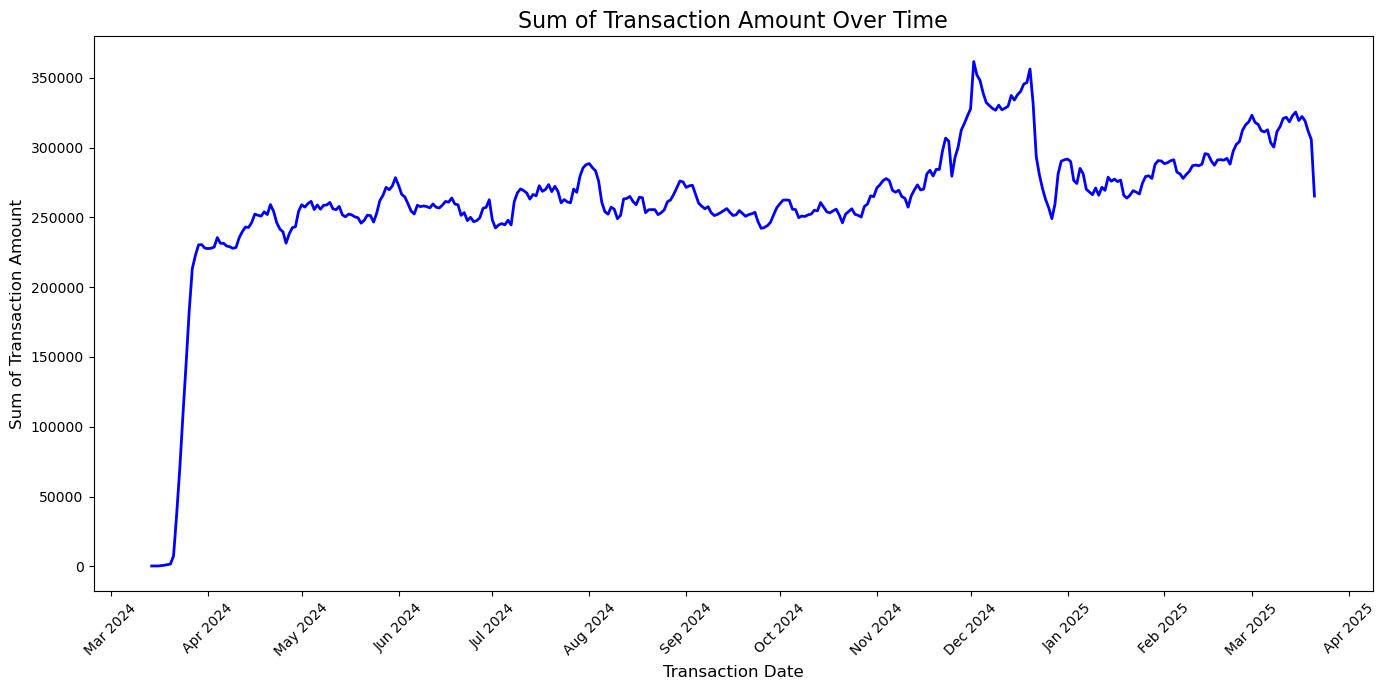

In [9]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Calculate the sum of transaction amounts grouped by transaction date
transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])
transaction_sum = transaction_sales_df.groupby('transaction_date')['transaction_amt'].sum()

# Filter data to start from March 2024
transaction_sum_filtered = transaction_sum[transaction_sum.index >= '2024-03-01']

transaction_sum_smoothed = transaction_sum_filtered.rolling(window=7, center=True).mean()

# Plot the sum of transaction amounts over time
plt.figure(figsize=(14, 7))
plt.plot(transaction_sum_smoothed.index, transaction_sum_smoothed.values, color='blue', linewidth=2, label='Transaction Amount')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Sum of Transaction Amount Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Sum of Transaction Amount', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

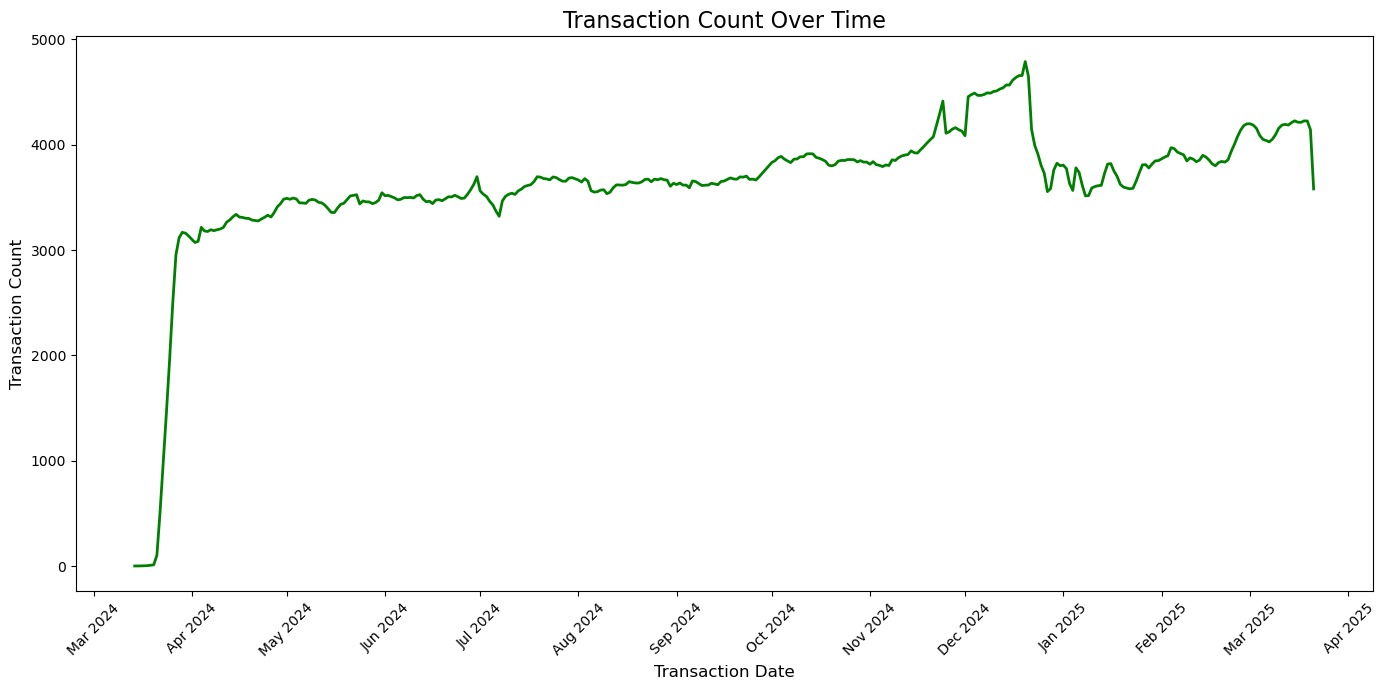

In [10]:
# Calculate the count of transactions grouped by transaction date
transaction_count = transaction_sales_df.groupby('transaction_date').size()

# Filter data to start from March 2024
transaction_count_filtered = transaction_count[transaction_count.index >= '2024-03-01']

transaction_count_smoothed = transaction_count_filtered.rolling(window=7, center=True).mean()

# Plot the transaction count over time
plt.figure(figsize=(14, 7))
plt.plot(transaction_count_smoothed.index, transaction_count_smoothed.values, color='green', linewidth=2, label='Transaction Count')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Transaction Count Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

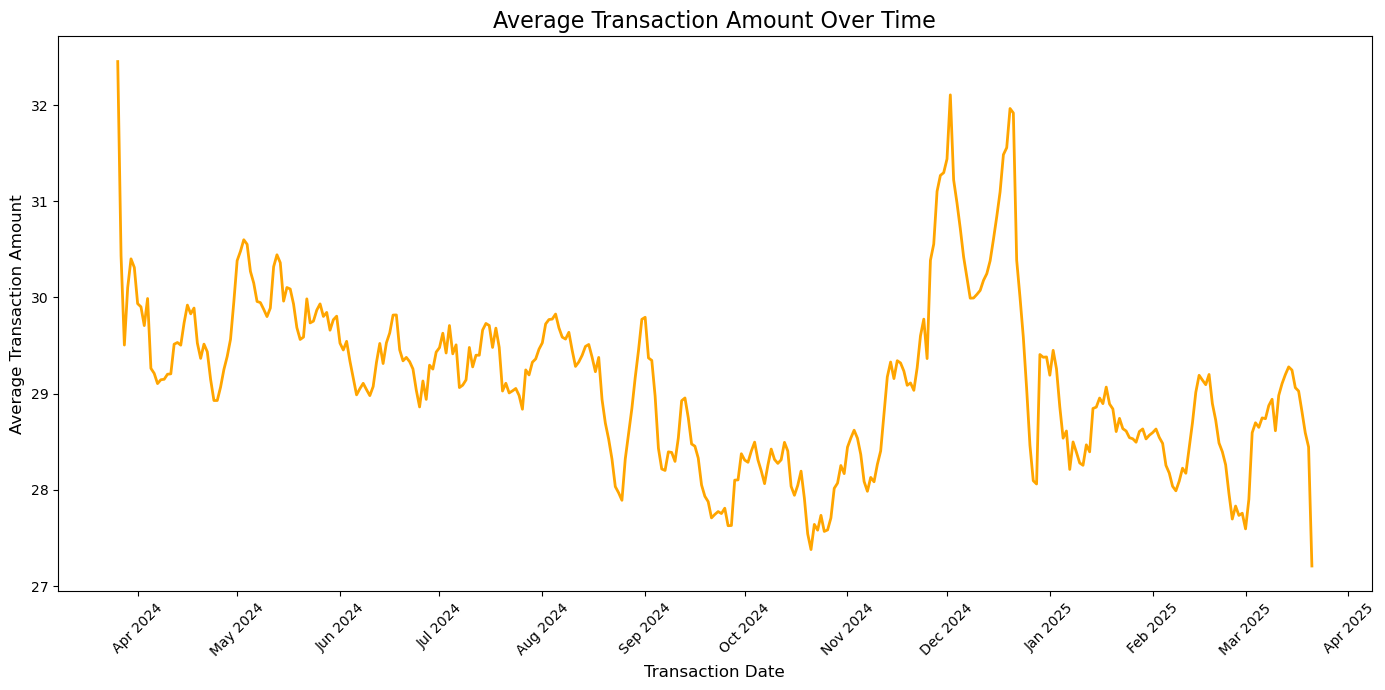

In [13]:
# Calculate the average transaction amount grouped by transaction date
average_transaction_amt = transaction_sales_df.groupby('transaction_date')['transaction_amt'].median()

# Filter data to start from March 2024
average_transaction_amt_filtered = average_transaction_amt[average_transaction_amt.index >= '2024-03-23'].rolling(window=7, center=True).mean()

# Plot the average transaction amount over time
plt.figure(figsize=(14, 7))
plt.plot(average_transaction_amt_filtered.index, average_transaction_amt_filtered.values, color='orange', linewidth=2, label='Average Transaction Amount')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Average Transaction Amount Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Average Transaction Amount', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Generate Forecasting Model

In [ ]:
# Convert transaction_date to datetime if not already
transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])

# Filter transactions between March 2024 and March 2025
filtered_transactions = transaction_sales_df[
    (transaction_sales_df['transaction_date'] >= '2024-03-01') &
    (transaction_sales_df['transaction_date'] <= '2025-03-31')
]

# Extract year and month from transaction_date
filtered_transactions['year_month'] = filtered_transactions['transaction_date'].dt.to_period('M')

# Group by account and count unique months
account_month_counts = filtered_transactions.groupby('current_account_nbr')['year_month'].nunique()

# Filter accounts with at least one transaction per month (13 months)
eligible_accounts = account_month_counts[account_month_counts == 13].index

# Filter the original dataframe for these accounts
filtered_accounts_df = transaction_sales_df[transaction_sales_df['current_account_nbr'].isin(eligible_accounts)]

C:\Users\mohi2\AppData\Local\Temp\ipykernel_22332\2545881629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])
C:\Users\mohi2\AppData\Local\Temp\ipykernel_22332\2545881629.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transactions['year_month'] = filtered_transactions['transaction_date'].dt.to_period('M')


current_account_nbr    1035964
transaction_type       1035964
transaction_code       1035964
transaction_date       1035964
transaction_amt        1035964
frgn_curr_code         1035964
frgn_tran_amt          1035964
us_equiv_amt           1035964
dtype: int64


,current_account_nbr,transaction_type,transaction_code,transaction_date,transaction_amt,frgn_curr_code,frgn_tran_amt,us_equiv_amt
12270,00iP5U82D8XwVQ9G,SALE,253,2024-03-26,7.10,840,7.10,0.0
18067,00iP5U82D8XwVQ9G,SALE,253,2024-03-26,7.10,840,7.10,0.0
369668,00iP5U82D8XwVQ9G,SALE,253,2024-03-27,5.88,840,5.88,0.0
380514,00iP5U82D8XwVQ9G,SALE,253,2024-03-27,10.80,840,10.80,0.0
386929,00iP5U82D8XwVQ9G,SALE,253,2024-03-27,10.80,840,10.80,0.0
192049,00iP5U82D8XwVQ9G,SALE,253,2024-03-29,4.83,840,4.83,0.0
74315,00iP5U82D8XwVQ9G,SALE,253,2024-03-30,7.51,840,7.51,0.0
75768,00iP5U82D8XwVQ9G,SALE,253,2024-03-30,8.13,840,8.13,0.0
78618,00iP5U82D8XwVQ9G,SALE,253,2024-03-30,7.51,840,7.51,0.0
79453,00iP5U82D8XwVQ9G,SALE,253,2024-03-30,3.80,840,3.80,0.0
